In [1]:
import xml
import cv2
import subprocess
import matplotlib.pyplot as plt
import sys

from pathlib import Path
import pytesseract
from pytesseract import Output

import re
from pprint import pprint

import inflection
import xmltodict
import numpy as np
import pandas as pd
import seaborn as sns
from operator import itemgetter

In [2]:
xml_annotations_path = Path("../xml_annotations/")
annotations_path = Path("../annotations/")
screenshots_path = Path("../screenshots/")

In [3]:
plt.style.use("seaborn-dark")
plt.rcParams["figure.figsize"] = 9/1.5, 16/1.5

# Process XML

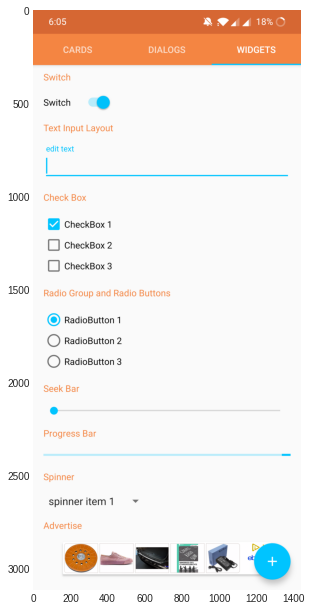

In [9]:
filename = (sorted(screenshots_path.glob("*.png"))[-1]).stem

xml_file = xml_annotations_path/f"full_{filename}.xml"
image_file = screenshots_path/f"{filename}.png"
csv_file = annotations_path/f"full_{filename}.csv"

image = cv2.imread(str(image_file))
plt.imshow(image)

# Parse XML

In [35]:
with open(xml_file) as fd:
    doc = xmltodict.parse(fd.read())

In [36]:
def get_widget_subclass(widget_class):
    return widget_class.split(".")[-1]

assert get_widget_subclass('android.widget.FrameLayout'), 'FrameLayout'

In [37]:
columns = ["widget_type", "classname", "xmin", "ymin", "xmax", "ymax", "text", "group"]

In [38]:
component_type_map = {
    "Spinner": "dropdown_menu",
    "TextView": "label",
    "EditText": "text_field",
    "CheckBox": "checkbox",
    "Button": "button",
    "Switch": "switch",
    "ImageButton": "icon_button",
    "CheckedTextView": "checkbox",
    "ProgressBar": "progress",
    "ToggleButton": "toggle_button",
    "Chip": "chip",
    "SeekBar": "slider",
    "ImageView": "image",
    "RadioButton": "radio_button"
}

checkable = ["checkbox", "switch", "toggle_button", "radio_button"]

layout_widgets = ["FrameLayout",
                  "ScrollView",
                  "LinearLayout",
                  "ViewGroup",
                  "LinearLayoutCompat",
                  "View",
                  "ViewPager",
                  "DrawerLayout",
                  "HorizontalScrollView",
                  "RelativeLayout"]

layout_type_map = dict(zip(layout_widgets, map(inflection.underscore, layout_widgets)))

def parse_annotation(obj):
    arr = []
    
    def extract(obj, arr, group):
        if isinstance(obj, dict):
            if "@class" in obj.keys():
                subclass = get_widget_subclass(obj["@class"])
                
                
                
                text = obj.get("@text", "")
                xmin, ymin, xmax, ymax = map(int, re.findall(r"\d+", obj["@bounds"]))
                
                
                if subclass in layout_widgets:
                    widget_type = "layout"
                    classname = layout_type_map.get(subclass, subclass)
                else:
                    widget_type = "component"
                    classname = component_type_map.get(subclass, subclass)
                
                if classname in checkable:
                    if classname == "slider":
                        classname += "_enabled" if obj["@checked"] == "true" else "_disabled"
                    else:
                        classname += "_checked" if obj["@checked"] == "true" else "_unchecked"
                    
                if classname == "label":
                    cropped_image = image[ymin:ymax, xmin:xmax]
                    d = pytesseract.image_to_data(cropped_image, output_type=Output.DICT)
                    bb_i = 0 if len(d['left']) == 1 else 1
                    (x, y, w, h) = (d['left'][bb_i], d['top'][bb_i], d['width'][bb_i], d['height'][bb_i])
                    xmin, ymin = xmin+x, ymin+y
                    xmax, ymax = xmin+w, ymin+h
                
                arr.append([widget_type, classname, xmin, ymin, xmax, ymax, text, group])
            
            for k, v in obj.items():                
                if isinstance(v, (dict, list)):
                    extract(v, arr, group)
        elif isinstance(obj, list):
            for i, item in enumerate(obj):
                extract(item, arr, f"{group}.{i+1}")

    try:
        extract(obj, arr, "1")
    except Exception as e:
        print(e.with_traceback())
    
    return arr
    

annotations = parse_annotation(doc)

annotations

[['layout', 'frame_layout', 37, 947, 1403, 2300, '', '1'],
 ['layout', 'linear_layout', 93, 1003, 1347, 2244, '', '1'],
 ['layout', 'frame_layout', 93, 1003, 1347, 2244, '', '1'],
 ['layout', 'frame_layout', 93, 1003, 1347, 2244, '', '1'],
 ['layout', 'frame_layout', 93, 1003, 1347, 2244, '', '1'],
 ['component', 'r0', 93, 1003, 1347, 2244, '', '1'],
 ['layout', 'linear_layout', 93, 1003, 1347, 1187, '', '1.1'],
 ['layout', 'linear_layout', 93, 1003, 1347, 1159, '', '1.1.1'],
 ['component', 'label', 180, 1088, 804, 1154, 'Single choice dialog', '1.1.1'],
 ['layout', 'view', 93, 1159, 1347, 1187, '', '1.1.2'],
 ['layout', 'frame_layout', 93, 1187, 1347, 2027, '', '1.2'],
 ['component', 'ListView', 93, 1187, 1347, 2027, '', '1.2'],
 ['component', 'checkbox_checked', 93, 1187, 1347, 1355, 'New York', '1.2.1'],
 ['component',
  'checkbox_unchecked',
  93,
  1355,
  1347,
  1523,
  'Los Angeles',
  '1.2.2'],
 ['component',
  'checkbox_unchecked',
  93,
  1523,
  1347,
  1691,
  'San Francis

# Test parsed XML

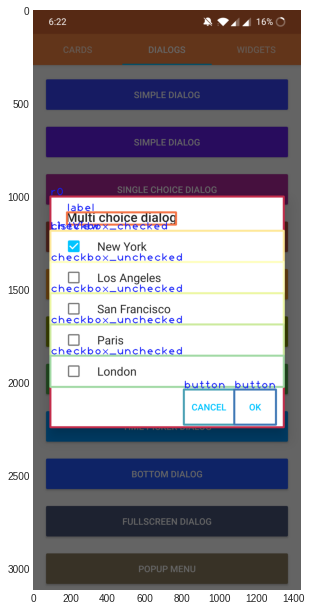

In [41]:
filename = (sorted(screenshots_path.glob("*.png"))[-1]).stem

xml_file = xml_annotations_path/f"full_{filename}.xml"
image_file = screenshots_path/f"{filename}.png"
csv_file = annotations_path/f"full_{filename}.csv"

image = cv2.imread(str(image_file))

annotation_df = pd.read_csv(csv_file)

a_count = len(annotation_df.group.unique())

color_palette = np.floor(np.array(sns.color_palette("Spectral", n_colors=a_count, desat=1)) * 255).astype(int).tolist()
color_map = dict(zip(annotation_df.group.unique(), color_palette))

get_pt1 = itemgetter("xmin", "ymin")
get_pt2 = itemgetter("xmax", "ymax")

boxed_image = image.copy()

for i, data in annotation_df[annotation_df.widget_type != "layout"].iterrows():
    pt1 = get_pt1(data)
    pt2 = get_pt2(data)
    
    color_value = color_map[data.group]
    cv2.rectangle(boxed_image, pt1, pt2, color_value, 10)
    cv2.putText(boxed_image, data.classname, (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_PLAIN, 4, (20, 30, 250), 3)

plt.imshow(boxed_image)